## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [4]:
df.count()

user_id         294478
timestamp       294478
group           294478
landing_page    294478
converted       294478
dtype: int64

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df.converted.sum()/df.converted.count()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
# newPage = df.query('landing_page=="new_page"')
# newPage.query('group!="treatment"').count()
# ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page')).sum()
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [8]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2=df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.user_id.duplicated() == True].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
# df2[df2.user_id.duplicated() == True]
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop(2893, inplace=True)
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.sum()/df2.converted.count()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
control = df2[df2.group=='control']['converted'].sum()/df2[df2.group=='control']['converted'].count()
control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
treatment = df2[df2.group=='treatment']['converted'].sum()/df2[df2.group=='treatment']['converted'].count()
treatment 

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2[df2.landing_page=='new_page'].count()/df2.count()

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Your answer goes here.**
There is insufficient evidence to support that the new treatment page leads to more conversion. This is because the conversion rate of the treatment is lower than both the control group, and that converting regardless of the page they receive.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**


$H_{0}$: **$p_{new}$** -**$p_{old}$** = 0


$H_{a}$: **$p_{new}$** - **$p_{old}$**  > 0 

Null hypothesis is that there is no difference between the conversion rate for the old pages and that for the new pages.

Alternative hypoethesis is that the conversion rate for the new pages is higher than that for the old pages.

p-value = 0.05

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2['converted'].sum()/df2['converted'].count()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2['converted'].sum()/df2['converted'].count()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new = df2[df2.group=='treatment']['user_id'].count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = df2[df2.group=='control']['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [59]:
# Use a sample size for each page equal to the ones in ab_data.csv 
# ie. 147239

# Perform the sampling distribution for the difference in converted 
# between the two pages over 10,000 iterations of calculating an estimate from the null.

# Simulate  𝑛𝑛𝑒𝑤  transactions 
# with a conversion rate of  𝑝𝑛𝑒𝑤  under the null. 
# for _ in range(n_new):
#     bootsample = np.random.sample()


new_page_converted = np.random.binomial(n=n_new, p=p_new)
new_page_converted 

17265

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [74]:
old_page_converted = np.random.binomial(p=p_old, n=n_old)
old_page_converted 

17410

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [75]:
p_new2 = new_page_converted/n_new
p_old2 = old_page_converted/n_old
p_new2 - p_old2


# p_new2 = new_page_converted.sum()/new_page_converted.count()
# p_old2 = old_page_converted.sum()/old_page_converted.count()



-0.001027557154788486

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [76]:
new_page_converted2 = np.random.binomial(n=n_new, p=p_new, size=10000)
old_page_converted2 = np.random.binomial(p=p_old, n=n_old, size=10000)
p_new3 = new_page_converted2/n_new
p_old3 = old_page_converted2/n_old
p_diffs = p_new3 - p_old3
p_diffs.mean()

2.5344913442698081e-05

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

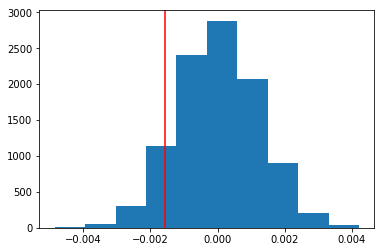

In [77]:
plt.hist(p_diffs);
# draw a line of the actual difference
plt.axvline(treatment-control, color='red');

My answer: This is the sampling distribution of the difference between old and new page's conversion rates with sample size of their respective size in the original sample dataset. It is centered around 0 because the conversion rates under null for both old and new page are equal, ie. there is no difference between rates.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [78]:
len(p_diffs[p_diffs>=(treatment-control)])/len(p_diffs)

0.9102

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**
91.02% of the p_diffs (i.e. null distribution, where we assume there is no difference between control and treatment group) are values greater than the actual difference observed in ab_data.csv. As we have type I error rate to be 5%, the probability of observing the actual difference, assuming the null hypothesis is true, is 91.02% ie. larger than the alpha 5%, therefore, there is insufficient evidence to reject the null hypothesis. We can say the observed difference is simply due to chance, not that there is a significant difference.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [67]:
import statsmodels.api as sm

convert_old = df2[df2['landing_page']=='old_page']['converted'].sum()
convert_new = df2[df2['landing_page']=='new_page']['converted'].sum()
n_old = df2[df2['landing_page']=='old_page']['user_id'].count()
n_new = df2[df2['landing_page']=='new_page']['user_id'].count()


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [71]:
stat, pval = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(stat, pval)
# statsmodels.stats.proportion.proportions_ztest(count, nobs, value=None, alternative='two-sided', prop_var=False)

1.31092419842 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**
As the p value of 0.91 is larger than the alpha of 0.05, there is insufficient evidence to reject the null. The z-score shows that (convertion for old pages - convertion for new pages) is at 1.31 sd from zero (the mean under null). Although the conclusion agrees with that in part j and k, the test statistic and the p-value here are slightly different to those we found in parts j and k because those in parts j and k were simulated.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**
Logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
# create dummy 
dummy = pd.get_dummies(df2['landing_page'])
df2['ab_page'] = dummy['new_page']

# create an intercept column
df2['intercept'] = 1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [40]:
y = df2['converted']
X = df2[['ab_page', 'intercept']]
model = sm.Logit(y, X)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [41]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-06-27 03:27 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
==================================================================

"""

In [81]:
# exponentiate the coefficient to find the effect
r = np.exp(-0.0150)

# reciprocate the result because it is a fraction
1/r

1.0151130646157189

So if an individual receive the new page, they are 1.02 times less likely to convert.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Put your answer here.**

The p-value is 0.1899 here, different from the one produced by simulation and by proportion z test in Part II.

The null here under this logistic regression model is that there is landing page does not affect convertion, i.e. no relationship between the landing page used and whether a user converts. The alternative is that landing page affects convertion, i.e. there is a relationship between the two. 

In this model, we did not specify what is the relationship, ie. if those receiving the old page have a higher chance to convert, or if those receiving the new page have a higher chance to convert. Therefore, it is a two-tailed test.

Whereas for the hypothesis in Part II, I specify in the alternative hypothesis that convertion rate for new page is larger than that for old page.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

consider other factors to add into your regression model

Advantage: Can see how each factor would contribute to whether an individual converts

Disadvantage: Factors might be correlated to each other, making the result insignificant

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [91]:
cdf = pd.read_csv('countries.csv')
cdf.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [93]:
df2 = df2.join(cdf.set_index('user_id'), on='user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US


In [95]:
df2.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [100]:
# create dummy 
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])
df2.tail()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,US,CA,UK
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,0,1,US,1,0,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,0,1,US,1,0,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,0,1,US,1,0,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,0,1,US,1,0,0
294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0,1,1,UK,0,0,1


In [101]:
y = df2['converted']
X = df2[['ab_page', 'US', 'CA', 'intercept']]
model = sm.Logit(y, X)
result = model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-06-27 04:13 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
US           -0.0099    0.0133    -0.7433  0.4573  -0.0359   0.0162
CA           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
intercept    -1.9794    0.0127  -155.4145  0.0000  -2.0044  -1.9544
==================================================================

"""

Does it appear that country had an impact on conversion? 

The coefficients for countries are both very small, even smaller than that for ab_page. The p values for countries also are larger than the alpha. Therefore country does not seem to have an impact on conversion.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [102]:
# create interaction columns
df2['ab_inter_us'] = df2['ab_page']*df2['US']
df2['ab_inter_ca'] = df2['ab_page']*df2['CA']
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,US,CA,UK,ab_inter_us,ab_inter_ca
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,1,0,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,1,0,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,1,0,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,1,0,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,1,0,0,0,0


In [103]:
y = df2['converted']
X = df2[['ab_page', 'US', 'CA', 'ab_inter_us', 'ab_inter_ca', 'intercept']]
model = sm.Logit(y, X)
result = model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-06-27 04:17 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
US            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
CA           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
ab_inter_us  -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
ab_inter_ca  -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
==================================================================

"""

The effects of attributes to conversion changed. 

Now, new_page and US have a positive effect on conversion respectively. But when an individual is in the US and reeive the new_page, the effect is negative on conversion rate. 

For the remaining variables including CA, and interaction between CA and new page, the effects are negative.

P-values of all variables are larger than the alpha 0.05. Therefore, there is not enough evidence to reject the null hypothesis and so we believe there's no relationship between all of these variables and the conversion rate.

<a id='conclusions'></a>

## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [106]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0